In [9]:
from PySDM.physics import si
from PySDM.initialisation.sampling.spectral_sampling import ConstantMultiplicity
from PySDM.initialisation.spectra.exponential import Exponential

n_sd = 2 ** 15
initial_spectrum = Exponential(norm_factor=8.39e12, scale=1.19e5 * si.um ** 3)
attributes = {}
attributes['volume'], attributes['multiplicity'] = ConstantMultiplicity(initial_spectrum).sample(n_sd)


In [10]:
import numpy as np
from PySDM import Builder
from PySDM.environments import Box
from PySDM.dynamics import Coalescence
from PySDM.dynamics.collisions.collision_kernels import Golovin
from PySDM.backends import CPU
from PySDM.products import ParticleVolumeVersusRadiusLogarithmSpectrum

radius_bins_edges = np.logspace(np.log10(10 * si.um), np.log10(5e3 * si.um), num=32)

env = Box(dt=1 * si.s, dv=1e6 * si.m ** 3)
builder = Builder(n_sd=n_sd, backend=CPU(), environment=env)
builder.add_dynamic(Coalescence(collision_kernel=Golovin(b=1.5e3 / si.s)))
products = [ParticleVolumeVersusRadiusLogarithmSpectrum(radius_bins_edges=radius_bins_edges, name='dv/dlnr')]
particulator = builder.build(attributes, products)

/Users/lursz/agh/ModellingPhysicalSystems/.venv/lib/python3.12/site-packages/PySDM/backends/numba.py:48: UserWarning: Disabling Numba threading due to ARM64 CPU (atomics do not work yet)
  warnings.warn(


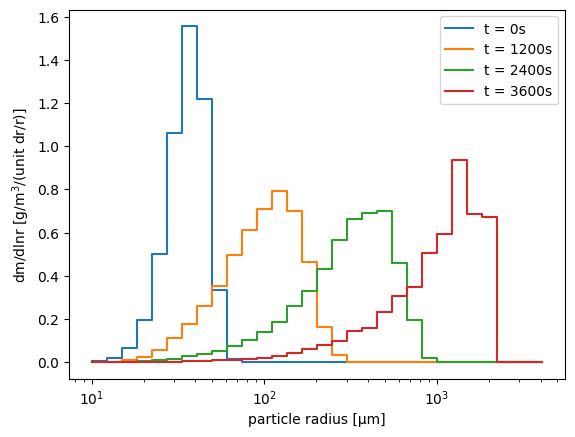

In [11]:
from matplotlib import pyplot

for step in [0, 1200, 2400, 3600]:
    particulator.run(step - particulator.n_steps)
    pyplot.step(
        x=radius_bins_edges[:-1] / si.um,
        y=particulator.formulae.particle_shape_and_density.volume_to_mass(
            particulator.products['dv/dlnr'].get()[0]
        ) / si.g,
        where='post', label=f"t = {step}s"
    )

pyplot.xscale('log')
pyplot.xlabel('particle radius [µm]')
pyplot.ylabel("dm/dlnr [g/m$^3$/(unit dr/r)]")
pyplot.legend()
pyplot.savefig('readme.png')

/Users/lursz/agh/ModellingPhysicalSystems/.venv/lib/python3.12/site-packages/PySDM/backends/numba.py:48: UserWarning: Disabling Numba threading due to ARM64 CPU (atomics do not work yet)
  warnings.warn(


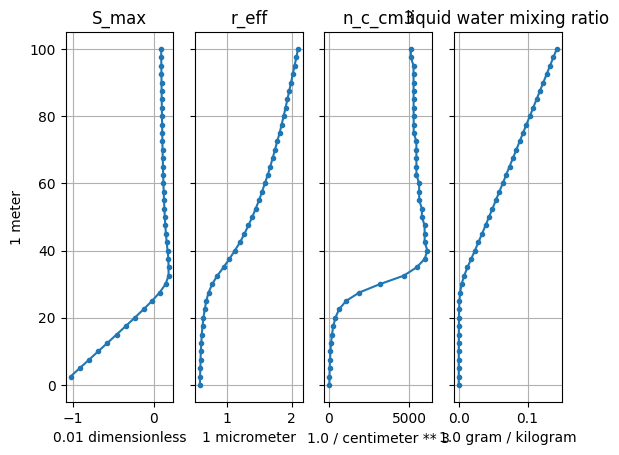

In [12]:
from matplotlib import pyplot
from PySDM.physics import si
from PySDM.initialisation import discretise_multiplicities, equilibrate_wet_radii
from PySDM.initialisation.spectra import Lognormal
from PySDM.initialisation.sampling import spectral_sampling
from PySDM.backends import CPU
from PySDM.dynamics import AmbientThermodynamics, Condensation
from PySDM.environments import Parcel
from PySDM import Builder, Formulae, products

env = Parcel(
  dt=.25 * si.s,
  mass_of_dry_air=1e3 * si.kg,
  p0=1122 * si.hPa,
  initial_water_vapour_mixing_ratio=20 * si.g / si.kg,
  T0=300 * si.K,
  w=2.5 * si.m / si.s
)
spectrum = Lognormal(norm_factor=1e4 / si.mg, m_mode=50 * si.nm, s_geom=1.5)
kappa = .5 * si.dimensionless
cloud_range = (.5 * si.um, 25 * si.um)
output_interval = 4
output_points = 40
n_sd = 256

formulae = Formulae()
builder = Builder(backend=CPU(formulae), n_sd=n_sd, environment=env)
builder.add_dynamic(AmbientThermodynamics())
builder.add_dynamic(Condensation())

r_dry, specific_concentration = spectral_sampling.Logarithmic(spectrum).sample(n_sd)
v_dry = formulae.trivia.volume(radius=r_dry)
r_wet = equilibrate_wet_radii(r_dry=r_dry, environment=builder.particulator.environment, kappa_times_dry_volume=kappa * v_dry)

attributes = {
  'multiplicity': discretise_multiplicities(specific_concentration * env.mass_of_dry_air),
  'dry volume': v_dry,
  'kappa times dry volume': kappa * v_dry,
  'volume': formulae.trivia.volume(radius=r_wet)
}

particulator = builder.build(attributes, products=[
  products.PeakSupersaturation(name='S_max', unit='%'),
  products.EffectiveRadius(name='r_eff', unit='um', radius_range=cloud_range),
  products.ParticleConcentration(name='n_c_cm3', unit='cm^-3', radius_range=cloud_range),
  products.WaterMixingRatio(name='liquid water mixing ratio', unit='g/kg', radius_range=cloud_range),
  products.ParcelDisplacement(name='z')
])

cell_id = 0
output = {product.name: [product.get()[cell_id]] for product in particulator.products.values()}

for step in range(output_points):
  particulator.run(steps=output_interval)
  for product in particulator.products.values():
    output[product.name].append(product.get()[cell_id])

fig, axs = pyplot.subplots(1, len(particulator.products) - 1, sharey="all")
for i, (key, product) in enumerate(particulator.products.items()):
  if key != 'z':
    axs[i].plot(output[key], output['z'], marker='.')
    axs[i].set_title(product.name)
    axs[i].set_xlabel(product.unit)
    axs[i].grid()
axs[0].set_ylabel(particulator.products['z'].unit)
pyplot.savefig('parcel.svg')